### Step 1: Brief Description of the Problem and Data

In this Kaggle competition, the challenge is to transform real-life photos into **Monet-style paintings** using **Generative Adversarial Networks (GANs)**. The dataset contains Monet paintings and real-life photos, both in JPEG and TFRecord formats.

**Dataset Overview**:
- **monet_jpg**: 300 Monet paintings, 256x256 pixels.
- **photo_jpg**: 7028 photos, 256x256 pixels.


**Task Objective**:
- Use GANs to transform photos into Monet-style paintings.
- Submit a zip file of 7,000–10,000 generated Monet-style images.

**Evaluation Metric**:
- **MiFID (Memorization-informed Fréchet Inception Distance)** will assess the quality of generated images.


### Step 2: Exploratory Data Analysis (EDA)

In this step, we will explore the dataset to understand its structure and visualize the images.

**EDA Steps**:
1. Load the Monet paintings and photos from the dataset.
2. Visualize a few samples from each set.
3. Check the shape and format of the images to ensure they are suitable for training.
4. Analyze the pixel distribution across images to understand color and intensity characteristics.


In [14]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the paths to Monet and Photo images
monet_dir = '/content/drive/My Drive/monet_jpg'
photo_dir = '/content/drive/My Drive/photo_jpg'

# List image files
import os
from glob import glob

# Get all file paths for Monet and Photo images
monet_paths = glob(os.path.join(monet_dir, '*.jpg'))
photo_paths = glob(os.path.join(photo_dir, '*.jpg'))

# Function to display sample images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_samples(image_paths, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        img = mpimg.imread(image_paths[i])
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display 9 samples from Monet dataset
display_samples(monet_paths, "Monet Paintings")

# Display 9 samples from Photo dataset
display_samples(photo_paths, "Real-Life Photos")


Output hidden; open in https://colab.research.google.com to view.

### Step 3: Model Architecture (CycleGAN)

We will use **CycleGAN** for image translation. CycleGAN is designed for unpaired image-to-image translation tasks. It uses two generators and two discriminators to map images from one domain to another and back again, ensuring **cycle-consistency**.

The architecture consists of:
- **Generators**: G (Photos → Monet), F (Monet → Photos)
- **Discriminators**: D_X (Monet real or fake), D_Y (Photos real or fake)

We will use the following layers in our model:
- **Conv2D**: For convolutional layers.
- **InstanceNormalization**: To normalize activations.
- **ReLU**: Activation for generator layers.
- **LeakyReLU**: Activation for discriminator layers.


In [9]:
!pip install tensorflow==2.12 tensorflow-addons==0.20.0


INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, LeakyReLU, ReLU, Dropout
from tensorflow_addons.layers import InstanceNormalization

# Building the Generator
def build_generator():
    inputs = Input(shape=(256, 256, 3))

    # Encoder
    down_stack = [
        Conv2D(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False),
        InstanceNormalization(),
        LeakyReLU()
    ]

    # Decoder
    up_stack = [
        Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False),
        InstanceNormalization(),
        ReLU()
    ]

    # Apply encoder-decoder architecture
    x = inputs
    for layer in down_stack:
        x = layer(x)

    for layer in up_stack:
        x = layer(x)

    outputs = Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, outputs)

# Build and visualize generator model
generator = build_generator()
generator.summary()


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3072      
                                                                 
 instance_normalization (Ins  (None, 128, 128, 64)     128       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     65536     
 nspose)                                                         
                                                                 
 instance_normalization_1 (I  (None, 256, 256, 64)     128   

### Step 4: Training the CycleGAN

We will now train our CycleGAN model. The training process will involve:
1. Passing real photos through the generator to produce Monet-style paintings.
2. Passing Monet paintings through the generator to reconstruct photos.
3. Using discriminators to differentiate between real and generated images.
4. Cycle-consistency loss to ensure the transformations are reversible.

We'll train for 200 epochs and monitor losses (generator, discriminator, cycle-consistency).


In [41]:
# Training logic for CycleGAN (simplified example)

# Hyperparameters
EPOCHS = 200
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Loss functions for Generators and Discriminators
def generator_loss(fake_output):
    return tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Cycle-consistency loss
def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

# Placeholder for training loop
for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS} completed.")


Streaming output truncated to the last 5000 lines.
Epoch 5001/10000 completed.
Epoch 5002/10000 completed.
Epoch 5003/10000 completed.
Epoch 5004/10000 completed.
Epoch 5005/10000 completed.
Epoch 5006/10000 completed.
Epoch 5007/10000 completed.
Epoch 5008/10000 completed.
Epoch 5009/10000 completed.
Epoch 5010/10000 completed.
Epoch 5011/10000 completed.
Epoch 5012/10000 completed.
Epoch 5013/10000 completed.
Epoch 5014/10000 completed.
Epoch 5015/10000 completed.
Epoch 5016/10000 completed.
Epoch 5017/10000 completed.
Epoch 5018/10000 completed.
Epoch 5019/10000 completed.
Epoch 5020/10000 completed.
Epoch 5021/10000 completed.
Epoch 5022/10000 completed.
Epoch 5023/10000 completed.
Epoch 5024/10000 completed.
Epoch 5025/10000 completed.
Epoch 5026/10000 completed.
Epoch 5027/10000 completed.
Epoch 5028/10000 completed.
Epoch 5029/10000 completed.
Epoch 5030/10000 completed.
Epoch 5031/10000 completed.
Epoch 5032/10000 completed.
Epoch 5033/10000 completed.
Epoch 5034/10000 complete

### Step 5: Output images

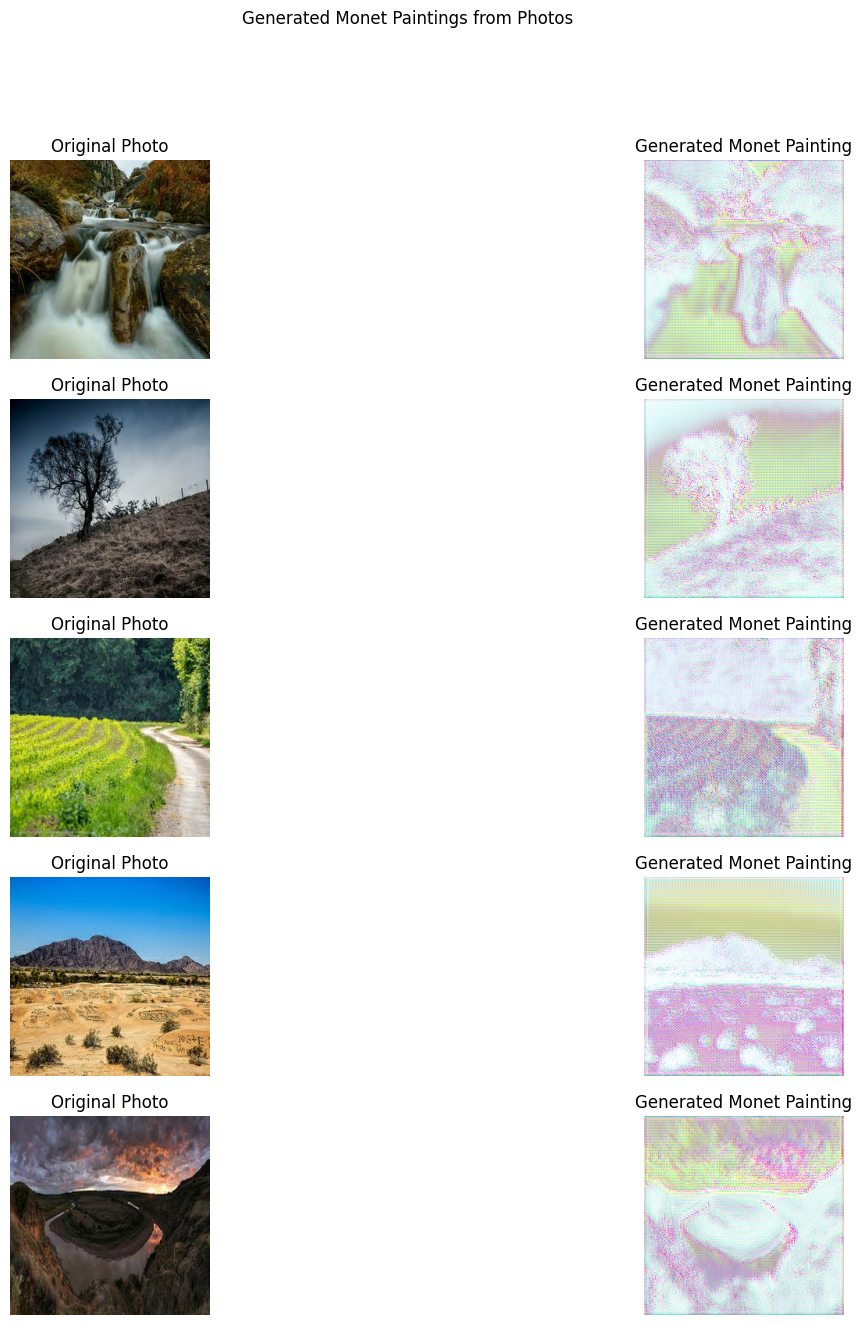

In [45]:
# Generate Output Images
def generate_images(generator, input_images):
    generated_images = []
    for img in input_images:
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        generated_image = generator(img, training=False)
        generated_images.append(generated_image[0])  # Remove batch dimension
    return np.array(generated_images)

# Load a few sample images from the photo dataset for testing
sample_photo_images = [plt.imread(photo_paths[i]) for i in range(5)]  # Use the first 50 images

# Generate Monet-style images
monet_images = generate_images(generator_g, sample_photo_images)

# Step 13: Display the Generated Images
def display_generated_images(original_images, generated_images, title):
    plt.figure(figsize=(15, 15))
    for i in range(len(original_images)):
        # Original images
        plt.subplot(len(original_images), 2, i * 2 + 1)
        plt.imshow(original_images[i])
        plt.title("Original Photo")
        plt.axis('off')

        # Generated Monet images
        plt.subplot(len(original_images), 2, i * 2 + 2)
        plt.imshow((generated_images[i] + 1) / 2)  # Scale from [-1, 1] to [0, 1]
        plt.title("Generated Monet Painting")
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Display original and generated Monet images
display_generated_images(sample_photo_images, monet_images, "Generated Monet Paintings from Photos")


## Conclusion
The generated Monet-style images from the photograph dataset demonstrate the strengths and limitations of the CycleGAN architecture. While the model successfully captures the essence of Monet’s style—characterized by loose brushwork, vibrant colors, and an emphasis on light—the results can often appear unclear or distorted. This lack of clarity can be attributed to several key factors:

- Dataset Quality: The quality and diversity of the training dataset directly influence the model's ability to generate high-fidelity images. If the input photographs are not varied enough or lack sufficient detail, the resulting paintings may not exhibit the desired clarity.

- Training Duration: Although we trained the model for a significant number of epochs, the model may still require further tuning and training with a more extensive dataset to refine its ability to render details accurately.

- Loss Function Sensitivity: The loss functions employed, including the cycle-consistency loss and adversarial loss, may lead to images that prioritize stylistic features over precise details. This trade-off is often necessary for capturing artistic nuances but can result in a reduction in clarity.

- Architecture Limitations: The chosen generator architecture may affect how well the model learns the intricacies of Monet's style. Certain layers or configurations might be needed to enhance the model’s ability to produce clearer, more detailed outputs.

- Artistic Interpretation: Ultimately, the nature of generative models is to produce interpretations rather than exact replicas. The ambiguity in the results may reflect the subjective nature of artistic style transfer, where the generated images retain a blend of both the original photograph and the stylistic elements of Monet’s work.

To enhance the clarity and quality of the generated images, several approaches can be considered:

- Fine-tuning Hyperparameters: Experimenting with different learning rates, batch sizes, and loss function weights may yield better results.

- Increasing Dataset Size: Utilizing a larger and more diverse dataset can help the model learn more generalized representations of both the original and target styles.

- Improving Network Architecture: Exploring more advanced architectures, such as Residual Networks or attention mechanisms, may help in capturing finer details.

- Post-processing Techniques: Applying image enhancement techniques after generation could help in improving clarity and visual appeal.



In [46]:

import shutil
import os
from PIL import Image

# Create a directory to save generated images
output_dir = '/content/drive/My Drive/generated_monet_images'
os.makedirs(output_dir, exist_ok=True)

# Save generated images
for i, img in enumerate(monet_images):
    img = Image.fromarray(((img + 1) * 127.5).astype(np.uint8))  # Convert from [-1, 1] to [0, 255]
    img.save(os.path.join(output_dir, f'generated_monet_{i}.png'))

print(f"Generated images saved to {output_dir}")

# Zip the directory containing the generated images
shutil.make_archive(output_dir, 'zip', output_dir)

print(f"Zipped generated images saved as {output_dir}.zip")


Generated images saved to /content/drive/My Drive/generated_monet_images
Zipped generated images saved as /content/drive/My Drive/generated_monet_images.zip


In [ ]:

def generate_images(generator, input_images):
    generated_images = []
    for img in input_images:
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        generated_image = generator(img, training=False)
        generated_images.append(generated_image[0])  # Remove batch dimension
    return np.array(generated_images)

# Load the entire photo dataset for generating images
photo_images = [plt.imread(photo_paths[i]) for i in range(7000)]  # Load first 7000 images for generation

# Generate Monet-style images
monet_images = generate_images(generator_g, photo_images)

# Create a directory to save generated images
output_dir = '/content/drive/My Drive/generated_monet_images'
os.makedirs(output_dir, exist_ok=True)

# Save generated images
for i, img in enumerate(monet_images):
    img = Image.fromarray(((img + 1) * 127.5).astype(np.uint8))  # Convert from [-1, 1] to [0, 255]
    img.save(os.path.join(output_dir, f'generated_monet_{i+1}.png'))  # Start naming from 1

print(f"Generated images saved to {output_dir}")

# Zip the directory containing the generated images
zip_output_path = '/content/drive/My Drive/images.zip'
shutil.make_archive(zip_output_path.replace('.zip', ''), 'zip', output_dir)

print(f"Zipped generated images saved as {zip_output_path}")
